In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection

import evopipe
import steps
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = 'wilt-train.csv'

data = pd.read_csv(filename, sep=',')
train_X = data[data.columns[1:]]
train_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = train_Y.index
train_Y = pd.Series(le.fit_transform(train_Y), index=ix)


test_filename = 'wilt-test.csv'

data = pd.read_csv(test_filename, sep=',')
test_X = data[data.columns[1:]]
test_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = test_Y.index
test_Y = pd.Series(le.fit_transform(test_Y), index=ix)

params = steps.get_params(len(train_X.iloc[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, pipe_params, n_jobs=-1, verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC


KeyboardInterrupt: 

In [3]:
scorer = metrics.make_scorer(metrics.cohen_kappa_score, weights='quadratic')
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, mutpb=0.5, swap_mutpb=0.4, len_mutpb = 0.2, param_mutpb=0.85,
                                ind_mutpb=0.8, scorer=scorer, ngen=100, pop_size=50)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe, score in best_pipes:
    pipe.fit(train_X, train_Y)
    # res_Y = pipe.predict(test_X)
    
    # score = metrics.cohen_kappa_score(test_Y, res_Y, weights='quadratic')
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))

evaluating: [('PCA', OrderedDict([('n_components', 5), ('whiten', False)])), ('Binarizer', OrderedDict()), ('NMF', OrderedDict([('n_components', 5), ('solver', 'cd')])), ('SVC', OrderedDict([('C', 0.5), ('gamma', 0.001), ('tol', 0.001)]))]Evolution starting...
evaluating: [('PCA', OrderedDict([('n_components', 5), ('whiten', False)])), ('Binarizer', OrderedDict()), ('NMF', OrderedDict([('n_components', 5), ('solver', 'cd')])), ('SVC', OrderedDict([('C', 0.5), ('gamma', 0.001), ('tol', 0.001)]))]
Gen 2:

evaluating: [('KNeighbors', OrderedDict([('algorithm', 'brute'), ('n_neighbors', 1)]))]
Gen 3:

evaluating: [('LDA', OrderedDict([('shrinkage', 'auto'), ('solver', 'eigen')]))]
Gen 4:

evaluating: [('Normalizer', OrderedDict()), ('logR', OrderedDict([('C', 1.0), ('penalty', 'l2'), ('solver', 'sag'), ('tol', 0.001)]))]
Gen 5:

evaluating: [('StandardScaler', OrderedDict()), ('Bagging', OrderedDict())]
Gen 6:

Hall of fame:
[('SVC', OrderedDict([('C', 15), ('gamma', 0.0001), ('tol', 0.000

   	                        fitness                         	              train_test             
   	--------------------------------------------------------	-------------------------------------
gen	var        	avg      	min         	max     	var        	avg    	min  	max  
0  	0.0763723  	0.145171 	-0.00544894 	0.839489	0.00658234 	0.64525	0.374	0.852
1  	0.115017   	0.437923 	0           	0.8381  	0.00855608 	0.7095 	0.456	0.862
2  	0.0407431  	0.645939 	0           	0.8381  	0.00272593 	0.76056	0.626	0.862
3  	0.0135353  	0.289899 	0           	0.8381  	0.000615014	0.73816	0.628	0.862
4  	0.0873321  	0.216491 	0           	0.8381  	0.00660013 	0.68548	0.626	0.862
5  	0.0226122  	0.732068 	0.00212477  	0.8381  	0.00271321 	0.80248	0.628	0.862
6  	0.108655   	0.209949 	0           	0.8381  	0.00751697 	0.67884	0.626	0.862
7  	0.0740888  	0.736315 	-0.00275511 	0.8381  	0.00630567 	0.83012	0.624	0.862
8  	0.0698408  	0.106509 	7.60708e-06 	0.8381  	0.00337734 	0.64832	0.626	0.862
9 

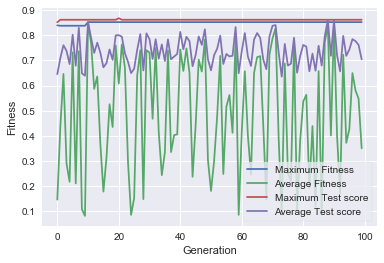

In [4]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, maxs, label='Maximum Fitness')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, avgs, label='Average Fitness')

line3 = ax1.plot(gen, maxs_tt, label='Maximum Test score')
line4 = ax1.plot(gen, avgs_tt, label='Average Test score')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
legend = plt.legend(lines, labels, loc='lower right', frameon=True)


plt.show()